## Set working directory

In [1]:
import os
os.chdir('/home/mhoerold/entrack')

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
import nibabel as nib
import copy

from src.baum_vagan.vagan.model_wrapper import VAGanWrapper
from src.baum_vagan.utils import ncc
from src.data.streaming.vagan_streaming import MRIImagePair, AgeFixedDeltaStream
from src.baum_vagan.utils import map_image_to_intensity_range

## Load model for evaluation

In [3]:
smt_label = "20180807-142109-debug"
config_path = os.path.join("data", smt_label, "config.yaml")
model_dir = os.path.join("data", smt_label, "logdir")
with open(config_path, 'r') as f:
    model_config = yaml.load(f)
wrapper = VAGanWrapper(**model_config)
wrapper.vagan.load_weights(model_dir)
vagan = wrapper.vagan

ADNI_AIBL has 387 files
1 images blacklisted
0 files found but not specified meta csv
Number of files: 387
Number of files missing: 19373
Splitting 218 images
Achieved train ratio: 0.757396449704142
>>>>>>>>> Sanity checks OK
>>>>>>>> Train stats
>>>>>>>>>>>>>>>>
>>>> Distinct patients: 28
>>>> Distinct images: 128
>>>> Age stats, mean=79.16326904296875, std=7.0446014404296875
>>>> Age diffences stats, mean=1.0612244606018066, std=0.3445294499397278
>>>> healthy count: 196 (1.0)
>>>> Gender 0: 128 (0.6530612244897959)
>>>> Gender 1: 68 (0.3469387755102041)
>>>>>>>>>>>>>>>>
>>>>>>>> Validation stats
>>>>>>>>>>>>>>>>
>>>> Distinct patients: 8
>>>> Distinct images: 51
>>>> Age stats, mean=76.2874984741211, std=6.852360248565674
>>>> Age diffences stats, mean=1.024999976158142, std=0.41758233308792114
>>>> healthy count: 80 (1.0)
>>>> Gender 0: 36 (0.45)
>>>> Gender 1: 44 (0.55)
>>>>>>>>>>>>>>>>
>>>>>>>> Test stats
>>>>>>>>>>>>>>>>
>>>> Distinct patients: 10
>>>> Distinct images: 41
>>>> A

2018-08-08 09:39:00,965 Summary name generator/conv1_1/conv1_1_conv/W:0 is illegal; using generator/conv1_1/conv1_1_conv/W_0 instead.


INFO:tensorflow:Summary name generator/conv1_2/conv1_2_conv/W:0 is illegal; using generator/conv1_2/conv1_2_conv/W_0 instead.


2018-08-08 09:39:01,005 Summary name generator/conv1_2/conv1_2_conv/W:0 is illegal; using generator/conv1_2/conv1_2_conv/W_0 instead.


INFO:tensorflow:Summary name generator/conv2_1/conv2_1_conv/W:0 is illegal; using generator/conv2_1/conv2_1_conv/W_0 instead.


2018-08-08 09:39:01,047 Summary name generator/conv2_1/conv2_1_conv/W:0 is illegal; using generator/conv2_1/conv2_1_conv/W_0 instead.


INFO:tensorflow:Summary name generator/conv2_2/conv2_2_conv/W:0 is illegal; using generator/conv2_2/conv2_2_conv/W_0 instead.


2018-08-08 09:39:01,090 Summary name generator/conv2_2/conv2_2_conv/W:0 is illegal; using generator/conv2_2/conv2_2_conv/W_0 instead.


INFO:tensorflow:Summary name generator/conv3_1/conv3_1_conv/W:0 is illegal; using generator/conv3_1/conv3_1_conv/W_0 instead.


2018-08-08 09:39:01,133 Summary name generator/conv3_1/conv3_1_conv/W:0 is illegal; using generator/conv3_1/conv3_1_conv/W_0 instead.


INFO:tensorflow:Summary name generator/conv3_2/conv3_2_conv/W:0 is illegal; using generator/conv3_2/conv3_2_conv/W_0 instead.


2018-08-08 09:39:01,175 Summary name generator/conv3_2/conv3_2_conv/W:0 is illegal; using generator/conv3_2/conv3_2_conv/W_0 instead.


INFO:tensorflow:Summary name generator/conv4_1/conv4_1_conv/W:0 is illegal; using generator/conv4_1/conv4_1_conv/W_0 instead.


2018-08-08 09:39:01,217 Summary name generator/conv4_1/conv4_1_conv/W:0 is illegal; using generator/conv4_1/conv4_1_conv/W_0 instead.


INFO:tensorflow:Summary name generator/conv4_2/conv4_2_conv/W:0 is illegal; using generator/conv4_2/conv4_2_conv/W_0 instead.


2018-08-08 09:39:01,257 Summary name generator/conv4_2/conv4_2_conv/W:0 is illegal; using generator/conv4_2/conv4_2_conv/W_0 instead.


INFO:tensorflow:Summary name generator/upconv3/W:0 is illegal; using generator/upconv3/W_0 instead.


2018-08-08 09:39:01,300 Summary name generator/upconv3/W:0 is illegal; using generator/upconv3/W_0 instead.


INFO:tensorflow:Summary name generator/conv5_1/conv5_1_conv/W:0 is illegal; using generator/conv5_1/conv5_1_conv/W_0 instead.


2018-08-08 09:39:01,344 Summary name generator/conv5_1/conv5_1_conv/W:0 is illegal; using generator/conv5_1/conv5_1_conv/W_0 instead.


INFO:tensorflow:Summary name generator/conv5_2/conv5_2_conv/W:0 is illegal; using generator/conv5_2/conv5_2_conv/W_0 instead.


2018-08-08 09:39:01,432 Summary name generator/conv5_2/conv5_2_conv/W:0 is illegal; using generator/conv5_2/conv5_2_conv/W_0 instead.


INFO:tensorflow:Summary name generator/upconv2/W:0 is illegal; using generator/upconv2/W_0 instead.


2018-08-08 09:39:01,476 Summary name generator/upconv2/W:0 is illegal; using generator/upconv2/W_0 instead.


INFO:tensorflow:Summary name generator/conv6_1/conv6_1_conv/W:0 is illegal; using generator/conv6_1/conv6_1_conv/W_0 instead.


2018-08-08 09:39:01,520 Summary name generator/conv6_1/conv6_1_conv/W:0 is illegal; using generator/conv6_1/conv6_1_conv/W_0 instead.


INFO:tensorflow:Summary name generator/conv6_2/conv6_2_conv/W:0 is illegal; using generator/conv6_2/conv6_2_conv/W_0 instead.


2018-08-08 09:39:01,559 Summary name generator/conv6_2/conv6_2_conv/W:0 is illegal; using generator/conv6_2/conv6_2_conv/W_0 instead.


INFO:tensorflow:Summary name generator/upconv1/W:0 is illegal; using generator/upconv1/W_0 instead.


2018-08-08 09:39:01,603 Summary name generator/upconv1/W:0 is illegal; using generator/upconv1/W_0 instead.


INFO:tensorflow:Summary name generator/conv8_1/conv8_1_conv/W:0 is illegal; using generator/conv8_1/conv8_1_conv/W_0 instead.


2018-08-08 09:39:01,647 Summary name generator/conv8_1/conv8_1_conv/W:0 is illegal; using generator/conv8_1/conv8_1_conv/W_0 instead.


INFO:tensorflow:Summary name generator/conv8_2/W:0 is illegal; using generator/conv8_2/W_0 instead.


2018-08-08 09:39:01,688 Summary name generator/conv8_2/W:0 is illegal; using generator/conv8_2/W_0 instead.


INFO:tensorflow:Summary name generator/conv8_2/b:0 is illegal; using generator/conv8_2/b_0 instead.


2018-08-08 09:39:01,690 Summary name generator/conv8_2/b:0 is illegal; using generator/conv8_2/b_0 instead.


INFO:tensorflow:Summary name critic/conv1_1/W:0 is illegal; using critic/conv1_1/W_0 instead.


2018-08-08 09:39:01,706 Summary name critic/conv1_1/W:0 is illegal; using critic/conv1_1/W_0 instead.


INFO:tensorflow:Summary name critic/conv1_1/b:0 is illegal; using critic/conv1_1/b_0 instead.


2018-08-08 09:39:01,707 Summary name critic/conv1_1/b:0 is illegal; using critic/conv1_1/b_0 instead.


INFO:tensorflow:Summary name critic/conv2_1/W:0 is illegal; using critic/conv2_1/W_0 instead.


2018-08-08 09:39:01,719 Summary name critic/conv2_1/W:0 is illegal; using critic/conv2_1/W_0 instead.


INFO:tensorflow:Summary name critic/conv2_1/b:0 is illegal; using critic/conv2_1/b_0 instead.


2018-08-08 09:39:01,720 Summary name critic/conv2_1/b:0 is illegal; using critic/conv2_1/b_0 instead.


INFO:tensorflow:Summary name critic/conv3_1/W:0 is illegal; using critic/conv3_1/W_0 instead.


2018-08-08 09:39:01,731 Summary name critic/conv3_1/W:0 is illegal; using critic/conv3_1/W_0 instead.


INFO:tensorflow:Summary name critic/conv3_1/b:0 is illegal; using critic/conv3_1/b_0 instead.


2018-08-08 09:39:01,733 Summary name critic/conv3_1/b:0 is illegal; using critic/conv3_1/b_0 instead.


INFO:tensorflow:Summary name critic/conv3_2/W:0 is illegal; using critic/conv3_2/W_0 instead.


2018-08-08 09:39:01,742 Summary name critic/conv3_2/W:0 is illegal; using critic/conv3_2/W_0 instead.


INFO:tensorflow:Summary name critic/conv3_2/b:0 is illegal; using critic/conv3_2/b_0 instead.


2018-08-08 09:39:01,744 Summary name critic/conv3_2/b:0 is illegal; using critic/conv3_2/b_0 instead.


INFO:tensorflow:Summary name critic/conv4_1/W:0 is illegal; using critic/conv4_1/W_0 instead.


2018-08-08 09:39:01,755 Summary name critic/conv4_1/W:0 is illegal; using critic/conv4_1/W_0 instead.


INFO:tensorflow:Summary name critic/conv4_1/b:0 is illegal; using critic/conv4_1/b_0 instead.


2018-08-08 09:39:01,756 Summary name critic/conv4_1/b:0 is illegal; using critic/conv4_1/b_0 instead.


INFO:tensorflow:Summary name critic/conv4_2/W:0 is illegal; using critic/conv4_2/W_0 instead.


2018-08-08 09:39:01,768 Summary name critic/conv4_2/W:0 is illegal; using critic/conv4_2/W_0 instead.


INFO:tensorflow:Summary name critic/conv4_2/b:0 is illegal; using critic/conv4_2/b_0 instead.


2018-08-08 09:39:01,769 Summary name critic/conv4_2/b:0 is illegal; using critic/conv4_2/b_0 instead.


INFO:tensorflow:Summary name critic/conv5_1/W:0 is illegal; using critic/conv5_1/W_0 instead.


2018-08-08 09:39:01,780 Summary name critic/conv5_1/W:0 is illegal; using critic/conv5_1/W_0 instead.


INFO:tensorflow:Summary name critic/conv5_1/b:0 is illegal; using critic/conv5_1/b_0 instead.


2018-08-08 09:39:01,781 Summary name critic/conv5_1/b:0 is illegal; using critic/conv5_1/b_0 instead.


INFO:tensorflow:Summary name critic/conv5_2/W:0 is illegal; using critic/conv5_2/W_0 instead.


2018-08-08 09:39:01,791 Summary name critic/conv5_2/W:0 is illegal; using critic/conv5_2/W_0 instead.


INFO:tensorflow:Summary name critic/conv5_2/b:0 is illegal; using critic/conv5_2/b_0 instead.


2018-08-08 09:39:01,793 Summary name critic/conv5_2/b:0 is illegal; using critic/conv5_2/b_0 instead.


INFO:tensorflow:Summary name critic/convD_1/W:0 is illegal; using critic/convD_1/W_0 instead.


2018-08-08 09:39:01,804 Summary name critic/convD_1/W:0 is illegal; using critic/convD_1/W_0 instead.


INFO:tensorflow:Summary name critic/convD_1/b:0 is illegal; using critic/convD_1/b_0 instead.


2018-08-08 09:39:01,805 Summary name critic/convD_1/b:0 is illegal; using critic/convD_1/b_0 instead.


INFO:tensorflow:Summary name critic/convD_2/W:0 is illegal; using critic/convD_2/W_0 instead.


2018-08-08 09:39:01,815 Summary name critic/convD_2/W:0 is illegal; using critic/convD_2/W_0 instead.


INFO:tensorflow:Summary name critic/convD_2/b:0 is illegal; using critic/convD_2/b_0 instead.


2018-08-08 09:39:01,817 Summary name critic/convD_2/b:0 is illegal; using critic/convD_2/b_0 instead.


Instructions for updating:
keep_dims is deprecated, use keepdims instead


2018-08-08 09:39:01,857 From /home/mhoerold/entrack/src/baum_vagan/tfwrapper/layers.py:49: calling reduce_mean (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


INFO:tensorflow:Summary name critic/critic_condition/conv1_1/W:0 is illegal; using critic/critic_condition/conv1_1/W_0 instead.


2018-08-08 09:39:01,868 Summary name critic/critic_condition/conv1_1/W:0 is illegal; using critic/critic_condition/conv1_1/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv1_1/b:0 is illegal; using critic/critic_condition/conv1_1/b_0 instead.


2018-08-08 09:39:01,870 Summary name critic/critic_condition/conv1_1/b:0 is illegal; using critic/critic_condition/conv1_1/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv2_1/W:0 is illegal; using critic/critic_condition/conv2_1/W_0 instead.


2018-08-08 09:39:01,880 Summary name critic/critic_condition/conv2_1/W:0 is illegal; using critic/critic_condition/conv2_1/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv2_1/b:0 is illegal; using critic/critic_condition/conv2_1/b_0 instead.


2018-08-08 09:39:01,881 Summary name critic/critic_condition/conv2_1/b:0 is illegal; using critic/critic_condition/conv2_1/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv3_1/W:0 is illegal; using critic/critic_condition/conv3_1/W_0 instead.


2018-08-08 09:39:01,891 Summary name critic/critic_condition/conv3_1/W:0 is illegal; using critic/critic_condition/conv3_1/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv3_1/b:0 is illegal; using critic/critic_condition/conv3_1/b_0 instead.


2018-08-08 09:39:01,893 Summary name critic/critic_condition/conv3_1/b:0 is illegal; using critic/critic_condition/conv3_1/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv3_2/W:0 is illegal; using critic/critic_condition/conv3_2/W_0 instead.


2018-08-08 09:39:01,903 Summary name critic/critic_condition/conv3_2/W:0 is illegal; using critic/critic_condition/conv3_2/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv3_2/b:0 is illegal; using critic/critic_condition/conv3_2/b_0 instead.


2018-08-08 09:39:01,905 Summary name critic/critic_condition/conv3_2/b:0 is illegal; using critic/critic_condition/conv3_2/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv4_1/W:0 is illegal; using critic/critic_condition/conv4_1/W_0 instead.


2018-08-08 09:39:01,916 Summary name critic/critic_condition/conv4_1/W:0 is illegal; using critic/critic_condition/conv4_1/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv4_1/b:0 is illegal; using critic/critic_condition/conv4_1/b_0 instead.


2018-08-08 09:39:01,918 Summary name critic/critic_condition/conv4_1/b:0 is illegal; using critic/critic_condition/conv4_1/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv4_2/W:0 is illegal; using critic/critic_condition/conv4_2/W_0 instead.


2018-08-08 09:39:01,927 Summary name critic/critic_condition/conv4_2/W:0 is illegal; using critic/critic_condition/conv4_2/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv4_2/b:0 is illegal; using critic/critic_condition/conv4_2/b_0 instead.


2018-08-08 09:39:01,929 Summary name critic/critic_condition/conv4_2/b:0 is illegal; using critic/critic_condition/conv4_2/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv5_1/W:0 is illegal; using critic/critic_condition/conv5_1/W_0 instead.


2018-08-08 09:39:01,940 Summary name critic/critic_condition/conv5_1/W:0 is illegal; using critic/critic_condition/conv5_1/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv5_1/b:0 is illegal; using critic/critic_condition/conv5_1/b_0 instead.


2018-08-08 09:39:01,942 Summary name critic/critic_condition/conv5_1/b:0 is illegal; using critic/critic_condition/conv5_1/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv5_2/W:0 is illegal; using critic/critic_condition/conv5_2/W_0 instead.


2018-08-08 09:39:01,953 Summary name critic/critic_condition/conv5_2/W:0 is illegal; using critic/critic_condition/conv5_2/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv5_2/b:0 is illegal; using critic/critic_condition/conv5_2/b_0 instead.


2018-08-08 09:39:01,955 Summary name critic/critic_condition/conv5_2/b:0 is illegal; using critic/critic_condition/conv5_2/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/convD_1/W:0 is illegal; using critic/critic_condition/convD_1/W_0 instead.


2018-08-08 09:39:01,965 Summary name critic/critic_condition/convD_1/W:0 is illegal; using critic/critic_condition/convD_1/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/convD_1/b:0 is illegal; using critic/critic_condition/convD_1/b_0 instead.


2018-08-08 09:39:01,967 Summary name critic/critic_condition/convD_1/b:0 is illegal; using critic/critic_condition/convD_1/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/convD_2/W:0 is illegal; using critic/critic_condition/convD_2/W_0 instead.


2018-08-08 09:39:01,976 Summary name critic/critic_condition/convD_2/W:0 is illegal; using critic/critic_condition/convD_2/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/convD_2/b:0 is illegal; using critic/critic_condition/convD_2/b_0 instead.


2018-08-08 09:39:01,978 Summary name critic/critic_condition/convD_2/b:0 is illegal; using critic/critic_condition/convD_2/b_0 instead.


INFO:tensorflow:Summary name critic/conv1_1/W:0 is illegal; using critic/conv1_1/W_0 instead.


2018-08-08 09:39:01,997 Summary name critic/conv1_1/W:0 is illegal; using critic/conv1_1/W_0 instead.


INFO:tensorflow:Summary name critic/conv1_1/b:0 is illegal; using critic/conv1_1/b_0 instead.


2018-08-08 09:39:01,999 Summary name critic/conv1_1/b:0 is illegal; using critic/conv1_1/b_0 instead.


INFO:tensorflow:Summary name critic/conv2_1/W:0 is illegal; using critic/conv2_1/W_0 instead.


2018-08-08 09:39:02,003 Summary name critic/conv2_1/W:0 is illegal; using critic/conv2_1/W_0 instead.


INFO:tensorflow:Summary name critic/conv2_1/b:0 is illegal; using critic/conv2_1/b_0 instead.


2018-08-08 09:39:02,005 Summary name critic/conv2_1/b:0 is illegal; using critic/conv2_1/b_0 instead.


INFO:tensorflow:Summary name critic/conv3_1/W:0 is illegal; using critic/conv3_1/W_0 instead.


2018-08-08 09:39:02,010 Summary name critic/conv3_1/W:0 is illegal; using critic/conv3_1/W_0 instead.


INFO:tensorflow:Summary name critic/conv3_1/b:0 is illegal; using critic/conv3_1/b_0 instead.


2018-08-08 09:39:02,011 Summary name critic/conv3_1/b:0 is illegal; using critic/conv3_1/b_0 instead.


INFO:tensorflow:Summary name critic/conv3_2/W:0 is illegal; using critic/conv3_2/W_0 instead.


2018-08-08 09:39:02,016 Summary name critic/conv3_2/W:0 is illegal; using critic/conv3_2/W_0 instead.


INFO:tensorflow:Summary name critic/conv3_2/b:0 is illegal; using critic/conv3_2/b_0 instead.


2018-08-08 09:39:02,019 Summary name critic/conv3_2/b:0 is illegal; using critic/conv3_2/b_0 instead.


INFO:tensorflow:Summary name critic/conv4_1/W:0 is illegal; using critic/conv4_1/W_0 instead.


2018-08-08 09:39:02,024 Summary name critic/conv4_1/W:0 is illegal; using critic/conv4_1/W_0 instead.


INFO:tensorflow:Summary name critic/conv4_1/b:0 is illegal; using critic/conv4_1/b_0 instead.


2018-08-08 09:39:02,026 Summary name critic/conv4_1/b:0 is illegal; using critic/conv4_1/b_0 instead.


INFO:tensorflow:Summary name critic/conv4_2/W:0 is illegal; using critic/conv4_2/W_0 instead.


2018-08-08 09:39:02,030 Summary name critic/conv4_2/W:0 is illegal; using critic/conv4_2/W_0 instead.


INFO:tensorflow:Summary name critic/conv4_2/b:0 is illegal; using critic/conv4_2/b_0 instead.


2018-08-08 09:39:02,032 Summary name critic/conv4_2/b:0 is illegal; using critic/conv4_2/b_0 instead.


INFO:tensorflow:Summary name critic/conv5_1/W:0 is illegal; using critic/conv5_1/W_0 instead.


2018-08-08 09:39:02,037 Summary name critic/conv5_1/W:0 is illegal; using critic/conv5_1/W_0 instead.


INFO:tensorflow:Summary name critic/conv5_1/b:0 is illegal; using critic/conv5_1/b_0 instead.


2018-08-08 09:39:02,039 Summary name critic/conv5_1/b:0 is illegal; using critic/conv5_1/b_0 instead.


INFO:tensorflow:Summary name critic/conv5_2/W:0 is illegal; using critic/conv5_2/W_0 instead.


2018-08-08 09:39:02,043 Summary name critic/conv5_2/W:0 is illegal; using critic/conv5_2/W_0 instead.


INFO:tensorflow:Summary name critic/conv5_2/b:0 is illegal; using critic/conv5_2/b_0 instead.


2018-08-08 09:39:02,044 Summary name critic/conv5_2/b:0 is illegal; using critic/conv5_2/b_0 instead.


INFO:tensorflow:Summary name critic/convD_1/W:0 is illegal; using critic/convD_1/W_0 instead.


2018-08-08 09:39:02,049 Summary name critic/convD_1/W:0 is illegal; using critic/convD_1/W_0 instead.


INFO:tensorflow:Summary name critic/convD_1/b:0 is illegal; using critic/convD_1/b_0 instead.


2018-08-08 09:39:02,050 Summary name critic/convD_1/b:0 is illegal; using critic/convD_1/b_0 instead.


INFO:tensorflow:Summary name critic/convD_2/W:0 is illegal; using critic/convD_2/W_0 instead.


2018-08-08 09:39:02,055 Summary name critic/convD_2/W:0 is illegal; using critic/convD_2/W_0 instead.


INFO:tensorflow:Summary name critic/convD_2/b:0 is illegal; using critic/convD_2/b_0 instead.


2018-08-08 09:39:02,056 Summary name critic/convD_2/b:0 is illegal; using critic/convD_2/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv1_1/W:0 is illegal; using critic/critic_condition/conv1_1/W_0 instead.


2018-08-08 09:39:02,062 Summary name critic/critic_condition/conv1_1/W:0 is illegal; using critic/critic_condition/conv1_1/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv1_1/b:0 is illegal; using critic/critic_condition/conv1_1/b_0 instead.


2018-08-08 09:39:02,064 Summary name critic/critic_condition/conv1_1/b:0 is illegal; using critic/critic_condition/conv1_1/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv2_1/W:0 is illegal; using critic/critic_condition/conv2_1/W_0 instead.


2018-08-08 09:39:02,069 Summary name critic/critic_condition/conv2_1/W:0 is illegal; using critic/critic_condition/conv2_1/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv2_1/b:0 is illegal; using critic/critic_condition/conv2_1/b_0 instead.


2018-08-08 09:39:02,071 Summary name critic/critic_condition/conv2_1/b:0 is illegal; using critic/critic_condition/conv2_1/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv3_1/W:0 is illegal; using critic/critic_condition/conv3_1/W_0 instead.


2018-08-08 09:39:02,077 Summary name critic/critic_condition/conv3_1/W:0 is illegal; using critic/critic_condition/conv3_1/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv3_1/b:0 is illegal; using critic/critic_condition/conv3_1/b_0 instead.


2018-08-08 09:39:02,079 Summary name critic/critic_condition/conv3_1/b:0 is illegal; using critic/critic_condition/conv3_1/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv3_2/W:0 is illegal; using critic/critic_condition/conv3_2/W_0 instead.


2018-08-08 09:39:02,084 Summary name critic/critic_condition/conv3_2/W:0 is illegal; using critic/critic_condition/conv3_2/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv3_2/b:0 is illegal; using critic/critic_condition/conv3_2/b_0 instead.


2018-08-08 09:39:02,085 Summary name critic/critic_condition/conv3_2/b:0 is illegal; using critic/critic_condition/conv3_2/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv4_1/W:0 is illegal; using critic/critic_condition/conv4_1/W_0 instead.


2018-08-08 09:39:02,090 Summary name critic/critic_condition/conv4_1/W:0 is illegal; using critic/critic_condition/conv4_1/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv4_1/b:0 is illegal; using critic/critic_condition/conv4_1/b_0 instead.


2018-08-08 09:39:02,093 Summary name critic/critic_condition/conv4_1/b:0 is illegal; using critic/critic_condition/conv4_1/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv4_2/W:0 is illegal; using critic/critic_condition/conv4_2/W_0 instead.


2018-08-08 09:39:02,097 Summary name critic/critic_condition/conv4_2/W:0 is illegal; using critic/critic_condition/conv4_2/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv4_2/b:0 is illegal; using critic/critic_condition/conv4_2/b_0 instead.


2018-08-08 09:39:02,099 Summary name critic/critic_condition/conv4_2/b:0 is illegal; using critic/critic_condition/conv4_2/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv5_1/W:0 is illegal; using critic/critic_condition/conv5_1/W_0 instead.


2018-08-08 09:39:02,104 Summary name critic/critic_condition/conv5_1/W:0 is illegal; using critic/critic_condition/conv5_1/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv5_1/b:0 is illegal; using critic/critic_condition/conv5_1/b_0 instead.


2018-08-08 09:39:02,106 Summary name critic/critic_condition/conv5_1/b:0 is illegal; using critic/critic_condition/conv5_1/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv5_2/W:0 is illegal; using critic/critic_condition/conv5_2/W_0 instead.


2018-08-08 09:39:02,111 Summary name critic/critic_condition/conv5_2/W:0 is illegal; using critic/critic_condition/conv5_2/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv5_2/b:0 is illegal; using critic/critic_condition/conv5_2/b_0 instead.


2018-08-08 09:39:02,112 Summary name critic/critic_condition/conv5_2/b:0 is illegal; using critic/critic_condition/conv5_2/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/convD_1/W:0 is illegal; using critic/critic_condition/convD_1/W_0 instead.


2018-08-08 09:39:02,117 Summary name critic/critic_condition/convD_1/W:0 is illegal; using critic/critic_condition/convD_1/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/convD_1/b:0 is illegal; using critic/critic_condition/convD_1/b_0 instead.


2018-08-08 09:39:02,118 Summary name critic/critic_condition/convD_1/b:0 is illegal; using critic/critic_condition/convD_1/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/convD_2/W:0 is illegal; using critic/critic_condition/convD_2/W_0 instead.


2018-08-08 09:39:02,122 Summary name critic/critic_condition/convD_2/W:0 is illegal; using critic/critic_condition/convD_2/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/convD_2/b:0 is illegal; using critic/critic_condition/convD_2/b_0 instead.


2018-08-08 09:39:02,124 Summary name critic/critic_condition/convD_2/b:0 is illegal; using critic/critic_condition/convD_2/b_0 instead.


INFO:tensorflow:Summary name critic/conv1_1/W:0 is illegal; using critic/conv1_1/W_0 instead.


2018-08-08 09:39:02,159 Summary name critic/conv1_1/W:0 is illegal; using critic/conv1_1/W_0 instead.


INFO:tensorflow:Summary name critic/conv1_1/b:0 is illegal; using critic/conv1_1/b_0 instead.


2018-08-08 09:39:02,161 Summary name critic/conv1_1/b:0 is illegal; using critic/conv1_1/b_0 instead.


INFO:tensorflow:Summary name critic/conv2_1/W:0 is illegal; using critic/conv2_1/W_0 instead.


2018-08-08 09:39:02,165 Summary name critic/conv2_1/W:0 is illegal; using critic/conv2_1/W_0 instead.


INFO:tensorflow:Summary name critic/conv2_1/b:0 is illegal; using critic/conv2_1/b_0 instead.


2018-08-08 09:39:02,167 Summary name critic/conv2_1/b:0 is illegal; using critic/conv2_1/b_0 instead.


INFO:tensorflow:Summary name critic/conv3_1/W:0 is illegal; using critic/conv3_1/W_0 instead.


2018-08-08 09:39:02,171 Summary name critic/conv3_1/W:0 is illegal; using critic/conv3_1/W_0 instead.


INFO:tensorflow:Summary name critic/conv3_1/b:0 is illegal; using critic/conv3_1/b_0 instead.


2018-08-08 09:39:02,173 Summary name critic/conv3_1/b:0 is illegal; using critic/conv3_1/b_0 instead.


INFO:tensorflow:Summary name critic/conv3_2/W:0 is illegal; using critic/conv3_2/W_0 instead.


2018-08-08 09:39:02,178 Summary name critic/conv3_2/W:0 is illegal; using critic/conv3_2/W_0 instead.


INFO:tensorflow:Summary name critic/conv3_2/b:0 is illegal; using critic/conv3_2/b_0 instead.


2018-08-08 09:39:02,180 Summary name critic/conv3_2/b:0 is illegal; using critic/conv3_2/b_0 instead.


INFO:tensorflow:Summary name critic/conv4_1/W:0 is illegal; using critic/conv4_1/W_0 instead.


2018-08-08 09:39:02,185 Summary name critic/conv4_1/W:0 is illegal; using critic/conv4_1/W_0 instead.


INFO:tensorflow:Summary name critic/conv4_1/b:0 is illegal; using critic/conv4_1/b_0 instead.


2018-08-08 09:39:02,186 Summary name critic/conv4_1/b:0 is illegal; using critic/conv4_1/b_0 instead.


INFO:tensorflow:Summary name critic/conv4_2/W:0 is illegal; using critic/conv4_2/W_0 instead.


2018-08-08 09:39:02,192 Summary name critic/conv4_2/W:0 is illegal; using critic/conv4_2/W_0 instead.


INFO:tensorflow:Summary name critic/conv4_2/b:0 is illegal; using critic/conv4_2/b_0 instead.


2018-08-08 09:39:02,194 Summary name critic/conv4_2/b:0 is illegal; using critic/conv4_2/b_0 instead.


INFO:tensorflow:Summary name critic/conv5_1/W:0 is illegal; using critic/conv5_1/W_0 instead.


2018-08-08 09:39:02,200 Summary name critic/conv5_1/W:0 is illegal; using critic/conv5_1/W_0 instead.


INFO:tensorflow:Summary name critic/conv5_1/b:0 is illegal; using critic/conv5_1/b_0 instead.


2018-08-08 09:39:02,262 Summary name critic/conv5_1/b:0 is illegal; using critic/conv5_1/b_0 instead.


INFO:tensorflow:Summary name critic/conv5_2/W:0 is illegal; using critic/conv5_2/W_0 instead.


2018-08-08 09:39:02,266 Summary name critic/conv5_2/W:0 is illegal; using critic/conv5_2/W_0 instead.


INFO:tensorflow:Summary name critic/conv5_2/b:0 is illegal; using critic/conv5_2/b_0 instead.


2018-08-08 09:39:02,268 Summary name critic/conv5_2/b:0 is illegal; using critic/conv5_2/b_0 instead.


INFO:tensorflow:Summary name critic/convD_1/W:0 is illegal; using critic/convD_1/W_0 instead.


2018-08-08 09:39:02,272 Summary name critic/convD_1/W:0 is illegal; using critic/convD_1/W_0 instead.


INFO:tensorflow:Summary name critic/convD_1/b:0 is illegal; using critic/convD_1/b_0 instead.


2018-08-08 09:39:02,273 Summary name critic/convD_1/b:0 is illegal; using critic/convD_1/b_0 instead.


INFO:tensorflow:Summary name critic/convD_2/W:0 is illegal; using critic/convD_2/W_0 instead.


2018-08-08 09:39:02,280 Summary name critic/convD_2/W:0 is illegal; using critic/convD_2/W_0 instead.


INFO:tensorflow:Summary name critic/convD_2/b:0 is illegal; using critic/convD_2/b_0 instead.


2018-08-08 09:39:02,282 Summary name critic/convD_2/b:0 is illegal; using critic/convD_2/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv1_1/W:0 is illegal; using critic/critic_condition/conv1_1/W_0 instead.


2018-08-08 09:39:02,289 Summary name critic/critic_condition/conv1_1/W:0 is illegal; using critic/critic_condition/conv1_1/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv1_1/b:0 is illegal; using critic/critic_condition/conv1_1/b_0 instead.


2018-08-08 09:39:02,291 Summary name critic/critic_condition/conv1_1/b:0 is illegal; using critic/critic_condition/conv1_1/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv2_1/W:0 is illegal; using critic/critic_condition/conv2_1/W_0 instead.


2018-08-08 09:39:02,297 Summary name critic/critic_condition/conv2_1/W:0 is illegal; using critic/critic_condition/conv2_1/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv2_1/b:0 is illegal; using critic/critic_condition/conv2_1/b_0 instead.


2018-08-08 09:39:02,299 Summary name critic/critic_condition/conv2_1/b:0 is illegal; using critic/critic_condition/conv2_1/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv3_1/W:0 is illegal; using critic/critic_condition/conv3_1/W_0 instead.


2018-08-08 09:39:02,304 Summary name critic/critic_condition/conv3_1/W:0 is illegal; using critic/critic_condition/conv3_1/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv3_1/b:0 is illegal; using critic/critic_condition/conv3_1/b_0 instead.


2018-08-08 09:39:02,306 Summary name critic/critic_condition/conv3_1/b:0 is illegal; using critic/critic_condition/conv3_1/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv3_2/W:0 is illegal; using critic/critic_condition/conv3_2/W_0 instead.


2018-08-08 09:39:02,310 Summary name critic/critic_condition/conv3_2/W:0 is illegal; using critic/critic_condition/conv3_2/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv3_2/b:0 is illegal; using critic/critic_condition/conv3_2/b_0 instead.


2018-08-08 09:39:02,312 Summary name critic/critic_condition/conv3_2/b:0 is illegal; using critic/critic_condition/conv3_2/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv4_1/W:0 is illegal; using critic/critic_condition/conv4_1/W_0 instead.


2018-08-08 09:39:02,317 Summary name critic/critic_condition/conv4_1/W:0 is illegal; using critic/critic_condition/conv4_1/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv4_1/b:0 is illegal; using critic/critic_condition/conv4_1/b_0 instead.


2018-08-08 09:39:02,319 Summary name critic/critic_condition/conv4_1/b:0 is illegal; using critic/critic_condition/conv4_1/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv4_2/W:0 is illegal; using critic/critic_condition/conv4_2/W_0 instead.


2018-08-08 09:39:02,323 Summary name critic/critic_condition/conv4_2/W:0 is illegal; using critic/critic_condition/conv4_2/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv4_2/b:0 is illegal; using critic/critic_condition/conv4_2/b_0 instead.


2018-08-08 09:39:02,325 Summary name critic/critic_condition/conv4_2/b:0 is illegal; using critic/critic_condition/conv4_2/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv5_1/W:0 is illegal; using critic/critic_condition/conv5_1/W_0 instead.


2018-08-08 09:39:02,331 Summary name critic/critic_condition/conv5_1/W:0 is illegal; using critic/critic_condition/conv5_1/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv5_1/b:0 is illegal; using critic/critic_condition/conv5_1/b_0 instead.


2018-08-08 09:39:02,333 Summary name critic/critic_condition/conv5_1/b:0 is illegal; using critic/critic_condition/conv5_1/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv5_2/W:0 is illegal; using critic/critic_condition/conv5_2/W_0 instead.


2018-08-08 09:39:02,338 Summary name critic/critic_condition/conv5_2/W:0 is illegal; using critic/critic_condition/conv5_2/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/conv5_2/b:0 is illegal; using critic/critic_condition/conv5_2/b_0 instead.


2018-08-08 09:39:02,340 Summary name critic/critic_condition/conv5_2/b:0 is illegal; using critic/critic_condition/conv5_2/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/convD_1/W:0 is illegal; using critic/critic_condition/convD_1/W_0 instead.


2018-08-08 09:39:02,346 Summary name critic/critic_condition/convD_1/W:0 is illegal; using critic/critic_condition/convD_1/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/convD_1/b:0 is illegal; using critic/critic_condition/convD_1/b_0 instead.


2018-08-08 09:39:02,348 Summary name critic/critic_condition/convD_1/b:0 is illegal; using critic/critic_condition/convD_1/b_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/convD_2/W:0 is illegal; using critic/critic_condition/convD_2/W_0 instead.


2018-08-08 09:39:02,352 Summary name critic/critic_condition/convD_2/W:0 is illegal; using critic/critic_condition/convD_2/W_0 instead.


INFO:tensorflow:Summary name critic/critic_condition/convD_2/b:0 is illegal; using critic/critic_condition/convD_2/b_0 instead.


2018-08-08 09:39:02,353 Summary name critic/critic_condition/convD_2/b:0 is illegal; using critic/critic_condition/convD_2/b_0 instead.


INFO:tensorflow:Restoring parameters from data/20180807-142109-debug/logdir/model.ckpt-0


2018-08-08 09:39:06,777 Restoring parameters from data/20180807-142109-debug/logdir/model.ckpt-0


In [4]:
## Some streamers
train_stream = lambda bs: wrapper.data.trainAD.next_batch(bs)[0]
validation_stream = lambda bs: wrapper.data.validationAD.next_batch(bs)[0]
test_stream = lambda bs: wrapper.data.testAD.next_batch(bs)[0]

n_train_samples = wrapper.data.n_train_samples
n_val_samples = wrapper.data.n_val_samples
n_test_samples = wrapper.data.n_test_samples

# Input wrapper
input_wrapper = wrapper.config.input_wrapper
gt_channel = 1

In [5]:
def extract_x_t0_x_t1_delta_x_t0(batch):
    x_t0 = batch[:, :, :, :, 0:1]
    delta_x_t0 = batch[:, :, :, :, 1:2]
    x_t1 = x_t0 + delta_x_t0
    return x_t0, x_t1, delta_x_t0

## Compute scores (e.g. NCC)

In [6]:
streamers = [
    {
        "streamer": test_stream,
        "name": "test",
        "n_samples": n_test_samples
    },
    {
        "streamer": validation_stream,
        "name": "validation",
        "n_samples": n_val_samples
    },
    {
        "streamer": train_stream,
        "name": "train",
        "n_samples": n_train_samples
    }
]

for s in streamers:
    stream = s["streamer"]
    name = s["name"]
    n_samples = s ["n_samples"]
    print("Evaluating {}".format(name))
    scores = []
    for _ in range(n_samples):
        inp = stream(1)
        diff_map = vagan.predict_mask(inp)
        # wrapped = input_wrapper(inp)
        gt = inp[:, :, :, :, gt_channel:gt_channel + 1]
        sc = ncc(diff_map, gt)
        scores.append(sc)
        
    print("NCC: mean {}, std {}, median {}"
          .format(np.mean(scores), np.std(scores), np.median(scores)))

Evaluating test
NCC: mean -0.0224372186857976, std 0.13540328231001497, median -0.01636842399141125
Evaluating validation
NCC: mean -0.027382341796520143, std 0.13384027099500032, median -0.03507832959970611
Evaluating train
NCC: mean -0.01697703913185615, std 0.1385793795165965, median -0.014735088097306278


## Analyze slices of generated difference map

In [ ]:
def plot_patient_slice(x_t0, x_t1, delta_x_t0, delta_gen, axis, slice_idx):
    x_t1_gen = x_t0 + delta_gen
    
    x_t0 = np.squeeze(np.take(x_t0, slice_idx, axis=axis))
    x_t1 = np.squeeze(np.take(x_t1, slice_idx, axis=axis))
    delta_x_t0 = np.squeeze(np.take(delta_x_t0, slice_idx, axis=axis))
    delta_gen = np.squeeze(np.take(delta_gen, slice_idx, axis=axis))
    x_t1_gen = np.squeeze(np.take(x_t1_gen, slice_idx, axis=axis))
    
    figsize = (20, 20)
    fs = 20
    fig = plt.figure(figsize=figsize, edgecolor='black', linewidth=0.1)
    plt.subplots_adjust(hspace=0.2, bottom=0.1)
    
    ax1 = fig.add_subplot(231)
    ax1.set_title("x_t0", size=fs)
    ax1.imshow(x_t0, cmap='gray')
    
    ax2 = fig.add_subplot(232)
    ax2.set_title("delta_x_t0", size=fs)
    ax2.imshow(delta_x_t0, cmap='gray')
    
    ax3 = fig.add_subplot(233)
    ax3.set_title("x_t1", size=fs)
    ax3.imshow(x_t1, cmap='gray')
    
    ax4 = fig.add_subplot(235)
    ax4.set_title("generated delta_x_t0", size=fs)
    ax4.imshow(delta_gen, cmap='gray')
    
    ax5 = fig.add_subplot(236)
    ax5.set_title("generated x_t1", size=fs)
    ax5.imshow(x_t1_gen, cmap='gray')
    
    for ax in [ax1, ax2, ax3, ax4, ax5]:
        ax.axis('off')
        
    fig.tight_layout()
    
n_samples = 20
for _ in range(n_samples):
    inp = test_stream(1)
    x_t0, x_t1, delta_x_t0 = extract_x_t0_x_t1_delta_x_t0(inp)
    delta_gen = vagan.predict_mask(inp)
    x_t1_gen = x_t0 + delta_gen
    
    plot_patient_slice(x_t0, x_t1, delta_x_t0, delta_gen, 1, 35)
    plot_patient_slice(x_t0, x_t1, delta_x_t0, delta_gen, 2, 59)
    plot_patient_slice(x_t0, x_t1, delta_x_t0, delta_gen, 3, 40)

## Iterative predictions

In [6]:
deltas = list(range(2, 11))
tol = 0.2
config = copy.deepcopy(wrapper.data.config)
delta_to_streamer = {}
for delta in deltas:
    config["delta_min"] = delta - tol
    config["delta_max"] = delta + tol
    config["normalize_images"] = False
    config["silent"] = True
    try:
        streamer = AgeFixedDeltaStream(config)
        streamer.all_pairs = streamer.train_pairs + streamer.test_pairs + streamer.val_pairs
        delta_to_streamer[delta] = streamer
    except:
        print("No streamer for delta = {}".format(delta))

No streamer for delta = 8
No streamer for delta = 9
No streamer for delta = 10


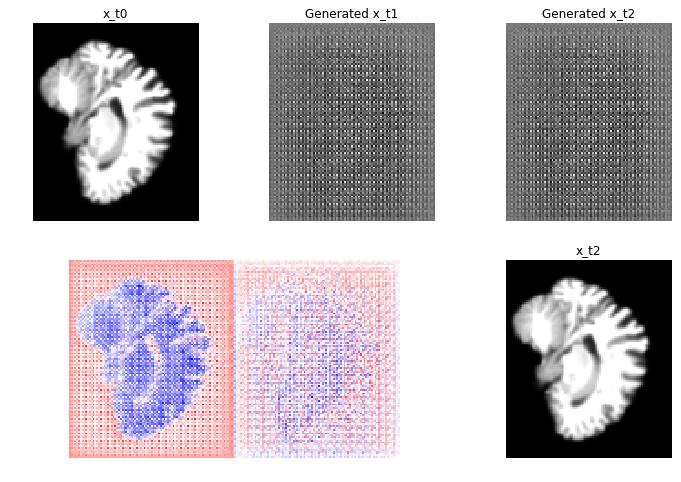

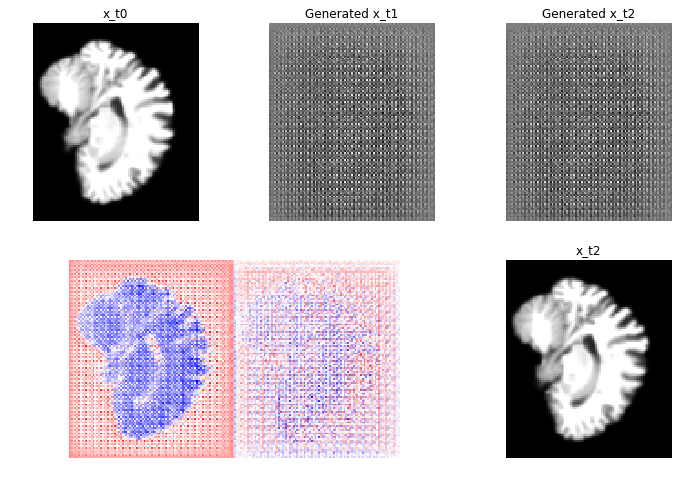

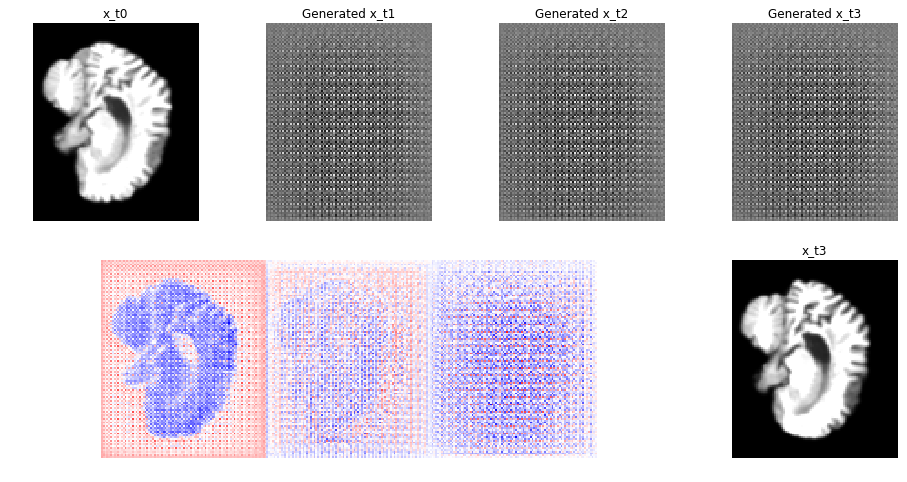

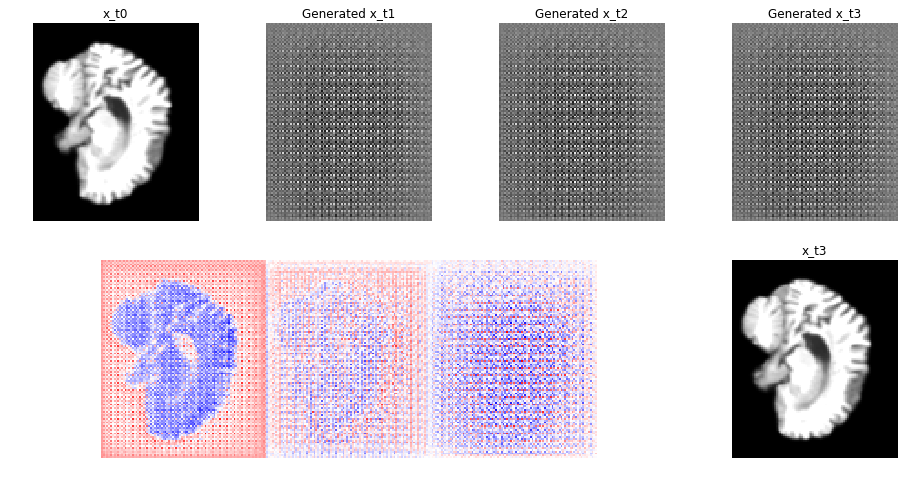

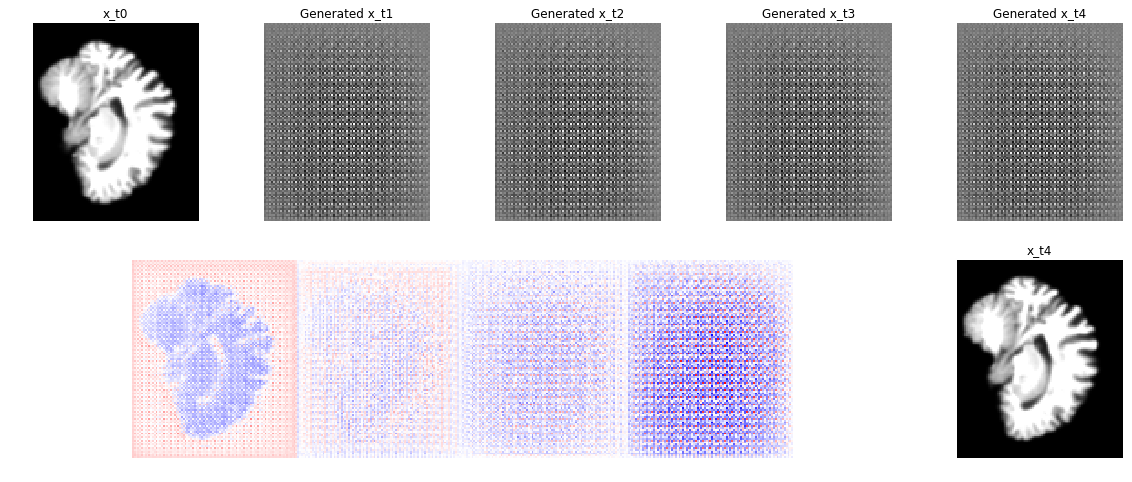

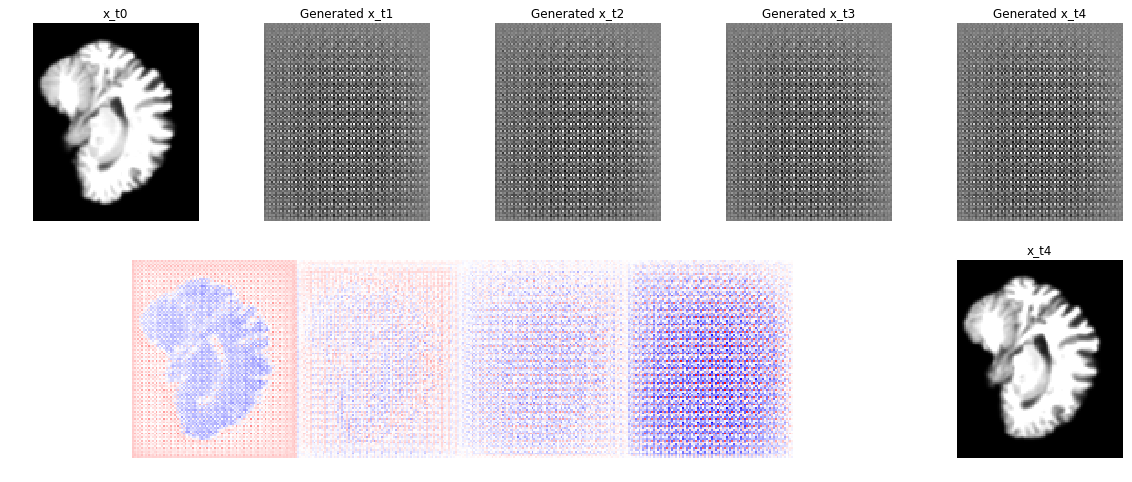

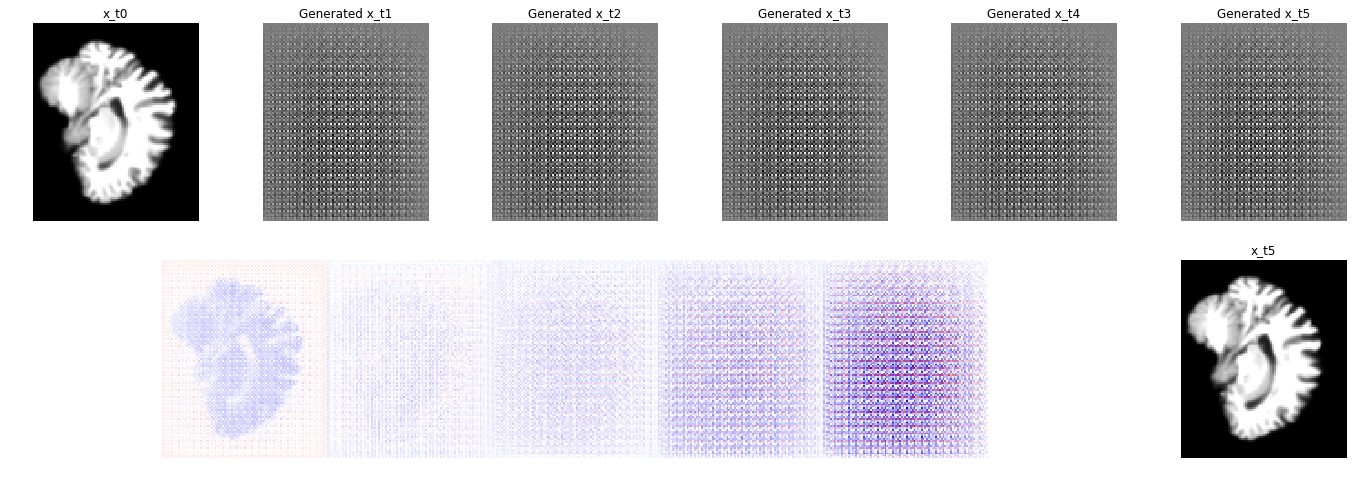

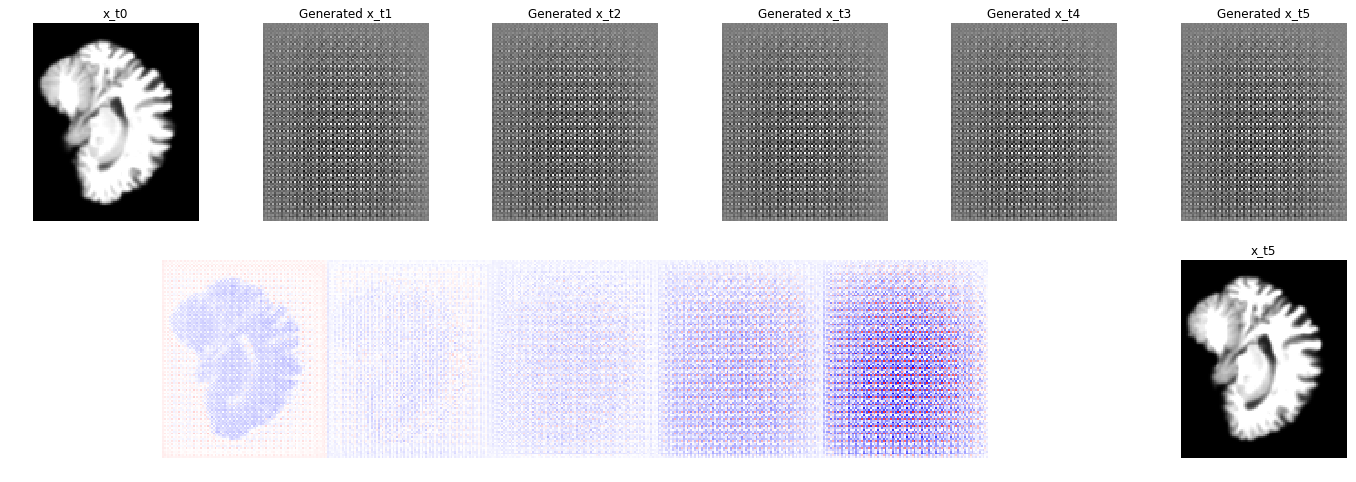

In [11]:
def iterate_model(model, img, n_steps):
    images = []
    masks = []
    # placeholder needs a second channel not used by generator
    img = np.concatenate((img, img), axis=-1)
    img = np.array([img])  # make a batch of size 1
    for _ in range(n_steps):
        M = model.predict_mask(img)
        masks.append(np.squeeze(M))
        img += M
        images.append(np.squeeze(img[:, :, :, :, 0]))
        # placeholder needs a second channel not used by generator
        # img = np.concatenate((img, img), axis=-1)
        
    return images, masks

def plot_iterative_predictions(pair, delta):
    # Use normalization of trained model
    # print(pair.get_age_delta())
    # print(pair.streamer.get_image_label(pair.fid1))
    pair = MRIImagePair(
        streamer=wrapper.data,
        fid1=pair.fid1,
        fid2=pair.fid2
    )
    x_t0 = pair.load_image(pair.fid1)
    x_tn = pair.load_image(pair.fid2)
    images, masks = iterate_model(wrapper.vagan, x_t0, delta)

    def get_slice(img):
        img = np.squeeze(img)
        return img[35, :, :]

    # plot predictions
    nrows = 2
    ncols = delta + 1
    fsize = 4
    plt.figure(figsize=(ncols * fsize, nrows * fsize))
    # plot images
    plt.subplot(nrows, ncols, 1)
    plt.imshow(get_slice(x_t0), cmap='gray')
    plt.title("x_t0")
    plt.axis('off')

    for i, img in enumerate(images):
        plt.subplot(nrows, ncols, i + 2)
        plt.imshow(get_slice(img), cmap='gray')
        plt.title('Generated x_t{}'.format(i + 1))
        plt.axis('off')

    # plot masks
    # concatenate differnce maps to plot with same scale
    plt.subplot(nrows, ncols, (ncols + 1, ncols + len(masks)))
    mask_slices = [get_slice(m) for m in masks]
    mask_slices_im = np.hstack(tuple(mask_slices))
    plt.imshow(mask_slices_im, cmap='bwr', vmin=-1, vmax=1)
    plt.axis('off')
    """
    for i, mask in enumerate(masks):
        plt.subplot(nrows, ncols, ncols + 1 + i)
        plt.imshow(get_slice(mask), cmap='bwr')
        plt.title('Generated diff map at t{}'.format(i))
        plt.axis('off')
    """

    # plot gt
    plt.subplot(nrows, ncols, nrows * ncols)
    plt.imshow(get_slice(x_tn), cmap='gray')
    plt.title('x_t{}'.format(delta))
    plt.axis('off')
    
for delta in range(2, 6): 
    pairs = delta_to_streamer[delta].all_pairs[:5]
    plot_iterative_predictions(pairs[1], delta)
    plot_iterative_predictions(pairs[0], delta)

In [22]:
np.squeeze(np.take(x_t0, [40], axis=2)).shape

(91, 91)

In [ ]:
test_ids = wrapper.data.get_test_ids()

for i, fid in enumerate(test_ids):
    path = wrapper.data.get_file_path(fid)
    p = MRIImagePair(wrapper.data, fid, fid)
    im = p.load_image(fid)
    lab = wrapper.data.get_image_label(fid)
    
    orig = nib.load(path).get_data()
    
    maxi = np.percentile(orig, 90)
    clipped = np.clip(orig, 0, 500)
    clipped_normed = wrapper.data.normalize_image(clipped)
    
    fig = plt.figure()
    plt.title("{}, min {}, max {}, std {}, 95perc {}".format(lab, np.min(orig), np.max(orig), np.std(orig), np.percentile(orig, 95)))
    ax1 = fig.add_subplot(131)
    ax1.imshow(im[:, 59, :, 0], cmap='gray')
    
    ax2 = fig.add_subplot(132)
    ax2.imshow(orig[:, 59, :], cmap='gray')
    
    ax3 = fig.add_subplot(133)
    ax3.set_title("std {}".format(np.std(clipped)))
    ax3.imshow(clipped_normed[:, 59, :], cmap='gray')
    

In [104]:
all_ids = wrapper.data.get_validation_ids().union(wrapper.data.get_test_ids()).union(wrapper.data.get_train_ids())

In [105]:
len(all_ids)

1737

In [106]:
high_stds = []
maxis = []
for fid in all_ids:
    im = wrapper.data.load_image(fid)
    std = np.std(im)
    maxis.append(np.max(im))
    if std > 1200:
        high_stds.append(fid)

In [13]:
len(high_stds)

16

In [ ]:
for fid in high_stds:
    lab = wrapper.data.get_image_label(fid)
    fig = plt.figure()
    plt.title(fid)
    im = wrapper.data.load_image(fid)
    ax1 = fig.add_subplot(131)
    ax1.imshow(im[:, 59, :], cmap='gray')
    
    normed = wrapper.data.normalize_image(im)
    ax2 = fig.add_subplot(132)
    ax2.imshow(normed[:, 59, :], cmap='gray')

In [94]:
fid = '/local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/60125_mni_aligned.nii.gz'
cur = wrapper.data.load_image(fid)

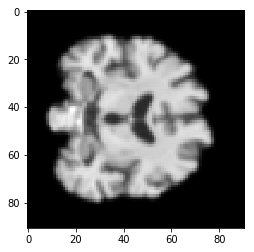

In [95]:
plt.imshow(cur[:, 59, :], cmap='gray')

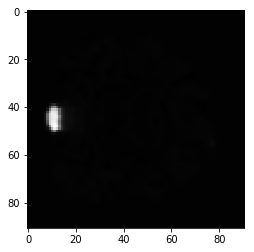

In [96]:
normed = wrapper.data.normalize_image(cur)
plt.imshow(normed[:, 59, :], cmap='gray')

(array([4456.,  190.,  190.,  278.,  316.,  454.,  570.,  813.,  990.,
          24.]),
 array([   0.        ,  462.58076172,  925.16152344, 1387.74228516,
        1850.32304688, 2312.90380859, 2775.48457031, 3238.06533203,
        3700.64609375, 4163.22685547, 4625.80761719]),
 <a list of 10 Patch objects>)

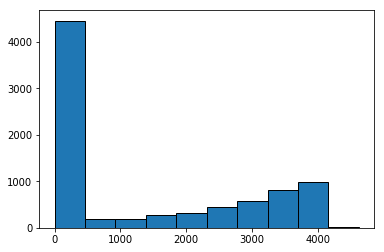

In [8]:
plt.hist(np.reshape(cur[:, 59, :], (-1, 1)), edgecolor='black')

(array([2.085e+03, 6.009e+03, 5.800e+01, 2.800e+01, 1.900e+01, 3.200e+01,
        2.900e+01, 8.000e+00, 3.000e+00, 1.000e+01]),
 array([-4.97628897, -0.17237927,  4.63153042,  9.43544011, 14.23934981,
        19.0432595 , 23.84716919, 28.65107888, 33.45498858, 38.25889827,
        43.06280796]),
 <a list of 10 Patch objects>)

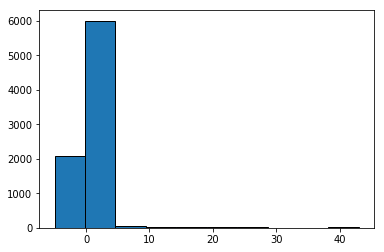

In [9]:
plt.hist(np.reshape(normed[:, 59, :], (-1, 1)), edgecolor='black')

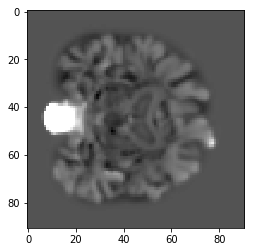

In [14]:
plt.imshow(np.clip(normed[:, 59, :], -10, 10), cmap='gray')

In [11]:
import inspect
lines = inspect.getsource(wrapper.data.normalize_image)
print(lines)

    def normalize_image(self, im):
        assert self.normalization_computed
        std = np.std(im)
        if np.isclose(0, std):
            std = 1
        im = (im - np.mean(im)) / std
        im = (im - self.voxel_means) / self.voxel_stds
        std = np.std(im)
        if np.isclose(0, std):
            std = 1
        im = (im - np.mean(im)) / std
        return im



In [99]:
def normalize_image(im):
    plt.figure()
    plt.imshow(im[:, 59, :], cmap='gray')
    std = np.std(im)
    print(std)
    if np.isclose(0, std):
        std = 1
        print("1: std is close to 0")
    im = (im - np.mean(im)) / std
    plt.figure()
    plt.imshow(im[:, 59, :], cmap='gray')
    plt.figure()
    plt.hist(np.reshape(im[:, 59, :], (1, -1)).ravel(), edgecolor='black')
    plt.show()
    im = (im - wrapper.data.voxel_means) / wrapper.data.voxel_stds
    plt.figure()
    plt.hist(np.reshape(im[:, 59, :], (1, -1)).ravel(), edgecolor='black')
    plt.show()
    plt.figure()
    plt.imshow(im[:, 59, :], cmap='gray')
    std = np.std(im)
    print(std)
    if np.isclose(0, std):
        std = 1
        print("2: std is close to 0")
    im = (im - np.mean(im)) / std
    plt.figure()
    plt.imshow(im[:, 59, :], cmap='gray')
    return im

1338.4634


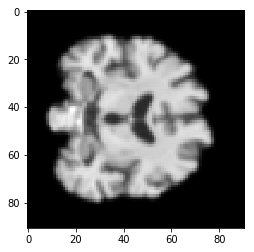

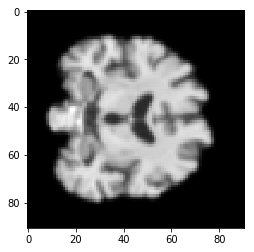

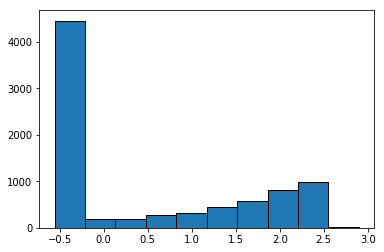

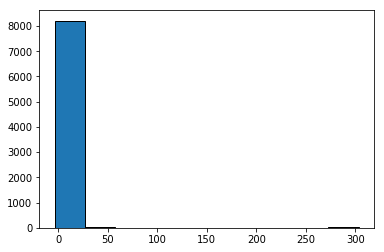

4.4738308182784765


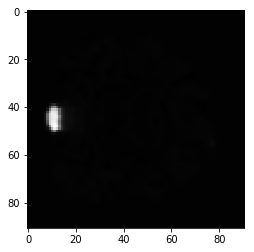

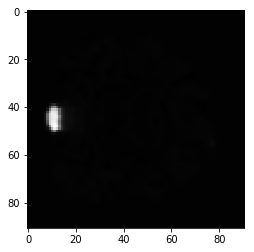

In [100]:
s = normalize_image(cur)

In [20]:
np.mean(cur)

745.2123

In [33]:
len(maxis)

1737

In [34]:
np.max(maxis)

5143.8975

(array([1219.,  239.,   76.,  105.,   64.,    8.,    4.,    6.,   14.,
           2.]),
 array([  47.84764481,  557.45262642, 1067.05760803, 1576.66258965,
        2086.26757126, 2595.87255287, 3105.47753448, 3615.0825161 ,
        4124.68749771, 4634.29247932, 5143.89746094]),
 <a list of 10 Patch objects>)

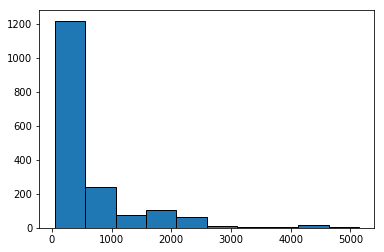

In [35]:
plt.hist(maxis, edgecolor='black')

In [37]:
maxi_perc = np.percentile(maxis, 95)

141.64664


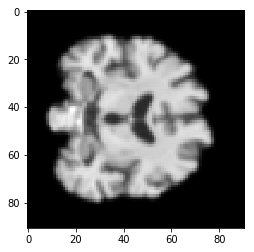

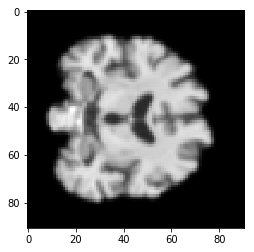

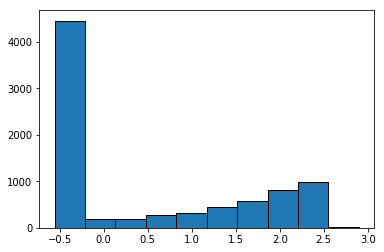

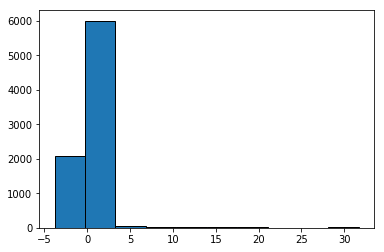

0.7392471879057763


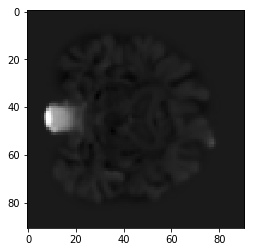

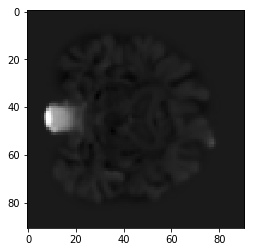

In [61]:
s = normalize_image(map_image_to_intensity_range(cur, 0, np.percentile(maxis, 70)))

1320.1125


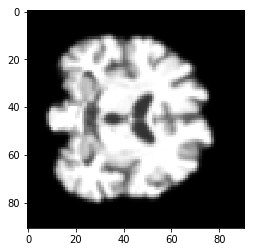

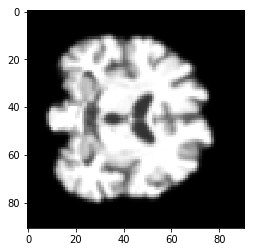

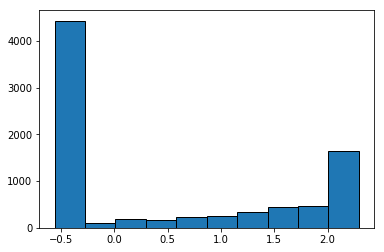

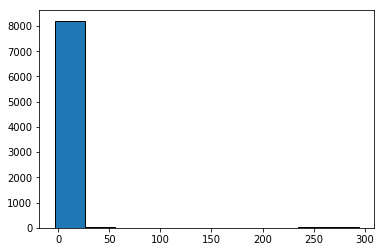

4.3683307831105855


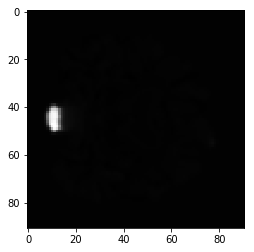

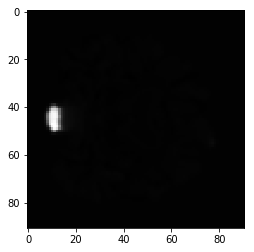

In [107]:
s = normalize_image(np.clip(cur, 0, np.percentile(cur, 95)))

In [42]:
np.percentile(cur, 95)

3763.848681640624